# Evaluate the plausibility

In [8]:
from Datasets.synthetics import Infection
import torch
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup PyG

In [9]:
torch.set_num_threads(4)
device = 'cpu'

from metrics.utils_nc import set_seeds

# Compute the plausibility

In [10]:
from metrics.utils_nc import load_graphs, get_roc_infection

from models.models_Infection import GCN_framework, GraphSAGE_framework, GAT_framework, GIN_framework, CHEB_framework


# Define the parameters
DATASET = 'Infection'
MODELS = ['GCN', 'GAT', 'GIN', 'GraphSAGE', 'Cheb']
EXPLS = ["subgraphX"]
MODES = ['train']

IGNORE = [('Infection', 'Cheb', 'gnnexpl', 'train'),
          ('Infection', 'Cheb', 'pgexplainer', 'train'),
          ('Infection', 'GIN', 'gnnexpl', 'train')]

GNN_NUM_LAYERS = {'GCN': 2, 'GAT': 2, 'GIN': 2, 'GraphSAGE': 2, 'Cheb': 2}


# Load the dataset
set_seeds()
dataset = Infection()
y = dataset.data.y.numpy()

# Define history variables
roc = {0: [], 1: [], 2: []}
model, expl = [], []

# Compute the metrics
for MODE in MODES:
    for MODEL in MODELS:
        print(8 * '* ' + MODEL + 8 * ' *')
        
        # Loop over the explainers
        for EXPL in EXPLS:
            # Define the setting and store it
            ID = (DATASET, MODEL, EXPL, MODE)
            model += [MODEL]
            expl += [EXPL]
            
            # Compute the sufficiency
            if ID in IGNORE:
                # Return nan metrics
                roc[0].append(float('nan'))
                roc[1].append(float('nan'))
                roc[2].append(float('nan'))
            else:
                # Load and filter the explanations
                graphs = load_graphs(DATASET, MODEL, EXPL, MODE, 
                          raw=False,
                          verbose=False,
                          lamb=0.001,
                          normalize=True)
                
                # Loop over the class labels
                for label in graphs:
                    if not graphs[label] == None:
                        # If there are valid explanations compute suff and comp    
                        roc[label] += [get_roc_infection(graphs, label, GNN_NUM_LAYERS[MODEL], y)]
                    else:
                        # Otherwise return nan metrics
                        roc[label].append(float('nan'))
                    
            # Print the partial results                    
            print(' '.join([' {:.3f}'.format(roc[label][-1]) if ~np.isnan(roc[label][-1]) else ' -----' for label in roc]) + '\t' + EXPL)                        

* * * * * * * * GCN * * * * * * * *


/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 0.500  0.500  0.500	subgraphX
* * * * * * * * GAT * * * * * * * *


/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 0.500  0.500  0.500	subgraphX
* * * * * * * * GIN * * * * * * * *


/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 0.500  0.500  0.500	subgraphX
* * * * * * * * GraphSAGE * * * * * * * *


/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 0.500  0.500  0.500	subgraphX
* * * * * * * * Cheb * * * * * * * *


/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 -----  -----  -----	subgraphX


In [11]:
import pandas as pd
results = pd.DataFrame({'model': model, 'expl': expl, 'class 0': roc[0], 'class 1': roc[1], 'class 2': roc[2]})
results.fillna(-100).to_csv('./metrics/plausibility_' + '_'.join(MODELS) + '.csv')
results

,model,expl,class 0,class 1,class 2
0,GCN,subgraphX,0.5,0.5,0.5
1,GAT,subgraphX,0.5,0.5,0.5
2,GIN,subgraphX,0.5,0.5,0.5
3,GraphSAGE,subgraphX,0.5,0.5,0.5
4,Cheb,subgraphX,NaN,NaN,NaN


array([[<Axes: title={'center': 'class 0'}>,
        <Axes: title={'center': 'class 1'}>],
       [<Axes: title={'center': 'class 2'}>, <Axes: >]], dtype=object)

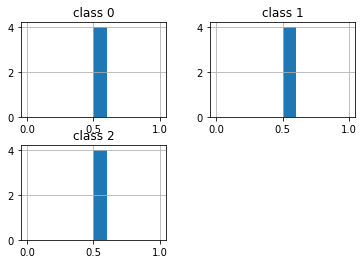

In [12]:
results.hist()